**Analisis de la Encuesta Continua de Hogares 2024**

- Dataset: https://www4.ine.gub.uy/Anda5/index.php/catalog/767/get-microdata
- Diccionario: https://www4.ine.gub.uy/Anda5/index.php/catalog/767/data-dictionary/F4?file_name=ECH_implantacion_2024

In [482]:
# CARGO EL CSV CON PANDAS
import pandas as pd
ech = pd.read_csv(r'C:\Users\ut603933\UM\tesis\ECH_implantacion_2024.csv')

In [483]:
# INFORMACION DEL DATASET
# print("Información del dataset de entrenamiento:")
# print(ech.info())
#print("\nResumen estadístico:")
#print(ech.describe())

In [484]:
# VERIFICAR VALORES NULOS
# print("Columnas con valores nulos (por nombre de la variable):")
# print(ech.isnull().sum()[ech.isnull().sum() > 0].sort_index())
#print("Columnas con valores nulos (ordenadas):")
#print(ech.isnull().sum()[ech.isnull().sum() > 0].sort_values(ascending=False))

In [485]:
# from tabulate import tabulate
# print(tabulate(ech, headers = 'keys', tablefmt = 'psql'))

In [486]:
# MOSTRAR EL DF
# pd.set_option('display.max_rows', None)  # Show all rows
# pd.set_option('display.max_columns', 10)  # Show all columns
# pd.set_option('display.width', 100)  # Adjust display width
# pd.set_option('display.max_colwidth', None)  # Show full column contents
# print(ech)
# #pd.reset_option('all') # Restore default option

In [487]:
# ech.sample(5)

In [488]:
# IMPORTO LIBRERIAS
#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [489]:
# === 1. Información general del dataset ===
print("Dimensiones del dataset:", ech.shape)
print("\nPrimeras filas:")
display(ech.head())

print("\nTipos de datos:")
display(ech.dtypes.value_counts())

Dimensiones del dataset: (55923, 535)

Primeras filas:


,ID,nper,anio,mes,GR,region,REGION_4,dpto,nom_dpto,ccz,barrio,secc,ESTRED13,LOC_AGR_13,NOM_LOC_AGR_13,c1,c2,c3,c4,c5_2,c5_10,c5_11,c5_12,c5_13,c6,c6_1,d8_1,d8_2,d8_3,d8_4,d9,d10,d11,d12,d13,d14,d15,d16,d18,d260,d19,d20,d21_1,d21_2,d21_3,d21_6,d21_4,d21_4_1,d21_5,d21_5_1,d21_20,d21_7,d21_10,d21_11,d21_12,d21_13,d21_14,d21_14_1,d21_15,d21_15_1,d21_15_2,d21_15_3,d21_15_4,d21_15_5,d21_15_6,d21_16,d21_16_1,d21_16_2,d21_21,d21_17,d21_18,d21_18_1,d21_19,d21_19_1,d181,d229,d230,d231,d232,d184,d184_1,d181_b,d184_b,d23,d24,d25,e557,e26,e27,e29_1,e29_2,e29_3,e29_4,e29_5,e29_6,e30,e31,e31_1,e32,e32_1,e33,e34,e35,e36,e185,e186_1,e186_2,e186_3,e186_4,e37,e37_2,e234_2,e38,e38_1,e39,e39_2,e235_2,e236,e236_2,e236_4,e45_cv,e45_1_1_cv,e45_1_1_1_cv,e45_2_1_cv,e45_2_1_1_cv,e45_3_1_cv,e45_3_1_1_cv,e45_4_1_cv,e45_4_1_1_cv,e45_cva,e45_cvb,e46_cv,e47_cv,e47_1_cv,e190,e48,e49,e49a,e579,e583,e581,e579a,e581a,e582,e582_1,e582_2,e582_3,e51_2,e197_1,e51_3,e51_4_a,e201_1a,e51_4_b,e201_1b,e51_5,e201_1c,e51_6,e201_1d,e209_1,e202,e51_6a,e51_6b,e214_1,e51_8,e215_1,e217_1,e51_9,e218_1,e220_1,e51_10,e221_1,e223_1,e51_11,e224_1,e226_1,e559,e559_1,e559_2,e584,e584_1,e59,e246,e247,f269,f270,f271,f272,f273,f69,f69_1,f274,f275,f276,f277,f70,f71_2,f72_2,f73,f82,f83,f84,f278,f278_a,f279,f280_1,f280_2,f280_3,f281_1,f281_2,f281_3,f281_4,f75,f76_2,f283,f81,f266,f266_1,f266_2,f267,f268,f77,f305,f306,f78,f80,f80_2,f284_1,f284_2,f284_3,f284_4,f284_5,f284_6,f284_7,f285,f286,f287,f85,f307,f308,f288,f289,f290,f291_a,f291_b,f292,f293,f294,f295,f90_2,f91_2,f92,f96,f97,f93,f94,f94_2,f296_1,f296_2,f296_3,f296_4,f296_5,f296_6,f296_7,f98,f99,f100,f101,f102,f103,f297,f298,f104,f299,f110,f111,f113,f114,f115,f300,f108,f301,f106,f116,f117,f118_1,f118_2,f122,f119_2,f120_2,f121,f123,f124_1,f124_2,f124_3,f124_5,f125,g_id_1,g_id_2,g_id_3,g_id_1a,g_id_2a,g_id_3a,g126_1,g126_2,g126_3,g126_4,g126_5,g126_6,g126_7,g126_8,g250_1,g250_2,g250_3,g250_4,g250_5,g127,g127_1,g127_2,g127_3,g128,g128_1,g129,g129_1,g129_2,g130,g130_1,g131,g131_1,g132,g132_1,g132_2,g132_3,g133,g133_1,g133_2,g_st_1,g134_1,g134_2,g134_3,g134_4,g134_5,g134_6,g134_7,g134_8,g251_1,g251_2,g251_3,g251_4,g251_5,g135,g135_1,g135_2,g135_3,g136,g136_1,g137,g137_1,g137_2,g138,g138_1,g139,g139_1,g140,g140_1,g140_2,g140_3,g141,g141_1,g141_2,g_itnd_1,g142,g_itnd_2,g143,g144,g144_1,g144_2_1,g144_2_2,g144_2_3,g144_2_4,g144_2_5,g_itnd_3,g259,g_it_1,g148_1_1,g148_1_2,g148_1_3,g148_1_5,g148_1_6,g148_1_7,g148_1_8,g148_1_9,g148_1_10,g148_1_11,g148_1_12,g_it_2,g148_2_1,g148_2_2,g148_2_3,g148_2_5,g148_2_6,g148_2_7,g148_2_8,g148_2_9,g148_2_10,g148_2_11,g148_2_12,g148_3,g148_4,g148_5_1,g148_5_2,g149,g149_1,g150,g255,g256,g152,g151_6,g151_3,g151_4,g257,g153,g153_1,g153_2,g258,g258_1,g154,g154_1,h155,h155_1,h156,h156_1,h272,h272_1,h273,h273_1,h274,h274_1,h274_2,h274_3,h252,h252_1,h158_1,h158_2,h159,h160,h160_1,h160_2,h161,h162,h163_1,h163_2,h164,h165,h227,h166,h269,h269_1,h167_1,h167_1_3,h167_2,h167_2_3,h167_3,h167_3_3,h167_4,h167_4_3,h169,h170_3,h271,h271_1,h171,h171_1,h171_2,h172,h172_1,h173,h173_1,i228,i174,i259,i175,eg_ahorro,eg_ps3,eg_ps4,eg_ps5,eg_ps6,eg_ps7,eg_ps8,eg_ps1,eg_ps2,POBPCOAC,SUBEMPLEO,MTO_CUOTA,MTO_EMER,MTO_HOGCON,MTO_DESAY,MTO_ALMUE,MTO_VACAS,MTO_OVEJA,MTO_CABALL,INDACELIAC,INDAEMER,PT1,PT2,PT4,HT11,HT19,HT13,YSVL,YHOG,AFAM_H_DEC,AFAM_H,TUS_H_DEC,TUS_H,USO_RRAA,pobre06,indig06,lp_06,li_06,pobre_multi,YDA_SVL,lp_17,li_17,pobre17,indig17,monto_imput_UTE,monto_imput_GAS,monto_imput_OSE,H_FONASA,montoGAS_RRAA,montoUTE_RRAA,montoOSE_RRAA,YDA,W_TRI,W_SEM,W_ANO
0,57612,1,2024,1,31,1,1,1,Montevideo,1,2,1,4,1010,Montevideo,3,1,1,1,2,2,2,2,NaN,1,0,5,0,18000,2,2,1,1,1,1,1,1,1,1,6,1,3,1,2,1,2,2,0,1,1,2,1,1,2,2,1,2,0,1,2,0,1,1,2,0,1,1,2,2,1,2,0,2,0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,NaN,NaN,1,0,1,1,2,70,2,2,1,2,2,0,1,0,0,0,0,2,0,0,4,1,0,2,0,1,1,0,0,1,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,1,7,0,1,2,0,3,1,1,20,0,0,0,0,0,0,0,0,0,6,1,0,3,1,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,2,0,0,2,2,0,0,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Tipos de datos:


int64      484
float64     49
object       2
Name: count, dtype: int64

In [490]:
# Mostrar todas las columnas sin truncar
pd.set_option('display.max_columns', None)  # muestra todas las columnas
pd.set_option('display.expand_frame_repr', False)  # evita salto de línea

# Mostrar todos los nombres de columna
print(ech.columns.tolist())

['ID', 'nper', 'anio', 'mes', 'GR', 'region', 'REGION_4', 'dpto', 'nom_dpto', 'ccz', 'barrio', 'secc', 'ESTRED13', 'LOC_AGR_13', 'NOM_LOC_AGR_13', 'c1', 'c2', 'c3', 'c4', 'c5_2', 'c5_10', 'c5_11', 'c5_12', 'c5_13', 'c6', 'c6_1', 'd8_1', 'd8_2', 'd8_3', 'd8_4', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd18', 'd260', 'd19', 'd20', 'd21_1', 'd21_2', 'd21_3', 'd21_6', 'd21_4', 'd21_4_1', 'd21_5', 'd21_5_1', 'd21_20', 'd21_7', 'd21_10', 'd21_11', 'd21_12', 'd21_13', 'd21_14', 'd21_14_1', 'd21_15', 'd21_15_1', 'd21_15_2', 'd21_15_3', 'd21_15_4', 'd21_15_5', 'd21_15_6', 'd21_16', 'd21_16_1', 'd21_16_2', 'd21_21', 'd21_17', 'd21_18', 'd21_18_1', 'd21_19', 'd21_19_1', 'd181', 'd229', 'd230', 'd231', 'd232', 'd184', 'd184_1', 'd181_b', 'd184_b', 'd23', 'd24', 'd25', 'e557', 'e26', 'e27', 'e29_1', 'e29_2', 'e29_3', 'e29_4', 'e29_5', 'e29_6', 'e30', 'e31', 'e31_1', 'e32', 'e32_1', 'e33', 'e34', 'e35', 'e36', 'e185', 'e186_1', 'e186_2', 'e186_3', 'e186_4', 'e37', 'e37_2', 'e234_2', 'e

In [491]:
# Ver si hay columnas duplicadas por nombre
duplicated_cols = ech.columns[ech.columns.duplicated()].tolist()
print("Columnas duplicadas por nombre:", duplicated_cols)

Columnas duplicadas por nombre: []


No hay columnas duplicadas en el dataset original. Las columnas que aparecen duplicadas y no permiten ejecutar el pipeline las repetimos erroneamente al categorizar las variables producto de que si aparecen duplicadas en el Excel del diccionario.

## Analisis exploratorio de datos

In [492]:
# === 2. Análisis de valores nulos ===
nulos = ech.isnull().sum()
nulos = nulos[nulos > 0].sort_values(ascending=False)
print("\nColumnas con nulos (cantidad):")
display(nulos)


Columnas con nulos (cantidad):


f295      28066
f293      28066
d229      28066
d230      28066
d231      28066
d232      28066
d184      28066
d184_1    28066
f294      28066
d181      28066
f288      28066
f289      28066
f290      28066
f291_a    28066
f291_b    28066
f292      28066
c5_13     27857
d181_b    27857
d184_b    27857
dtype: int64

Verificando el diccionario, los valores nulos son para las variables:
- c5_13: PROBLEMAS DE LA VIVIENDA Pisos y muros agrietados
- d181, d181_b, d184, d184_1, d184_b, d229, d230, d231, d232: SERVICIO DOMESTICO
- f288, f289, f290, f291_a, f291_b, f292, f293, f294, f295: Lugar y modalidad de trabajo

In [493]:
nulos_pct = ech.isnull().mean().sort_values(ascending=False)
display(nulos_pct[nulos_pct > 0])

f288      0.501869
f295      0.501869
d231      0.501869
d230      0.501869
d229      0.501869
d181      0.501869
d184_1    0.501869
d184      0.501869
f289      0.501869
f290      0.501869
f291_a    0.501869
f291_b    0.501869
f292      0.501869
f293      0.501869
f294      0.501869
d232      0.501869
d181_b    0.498131
d184_b    0.498131
c5_13     0.498131
dtype: float64

Las preguntas son de los modulos:
-   Servicio doméstico → sólo hogares que contratan personal.
-   Lugar y modalidad de trabajo → sólo personas ocupadas.

Confirmamos que son variables condicionales por diseño: 
-   La mitad de la población no responde esas preguntas porque no aplica.
-   El 50% restante sí tiene datos válidos y útiles.

No eliminamos esas columnas por tener “demasiados nulos”, ya que no se trata de datos ausentes por error, sino de lógica del cuestionario.

Podemos usarlas de forma segmentada, por ejemplo:
-   Hacer modelos distintos para personas ocupadas (que tienen datos en f288–f295) y no ocupadas, o
-   Incluir una variable indicadora de “aplica o no aplica” para evitar que el modelo se confunda.

Son una señal indirecta de pertenencia a ciertos grupos: tener datos en esas columnas podría implicar estar ocupado o tener personal a cargo → lo que sí puede estar correlacionado con el ingreso.


Estadísticas de ingreso (YDA):


count    5.592300e+04
mean     1.063283e+05
std      9.331071e+04
min      0.000000e+00
25%      5.400000e+04
50%      8.187355e+04
75%      1.270000e+05
max      2.560000e+06
Name: YDA, dtype: float64

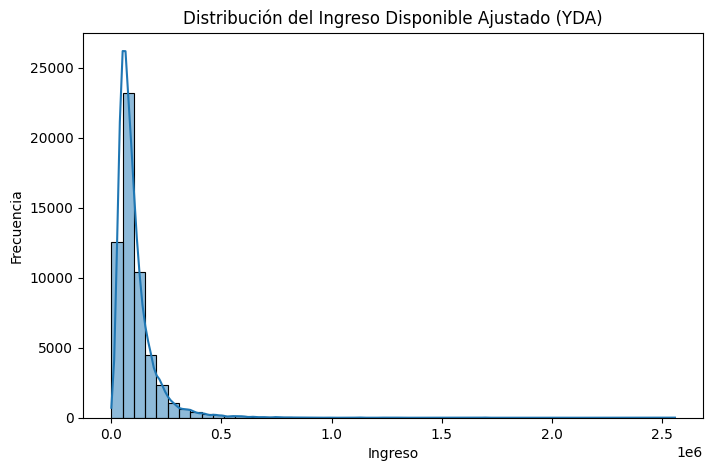

In [494]:
# === 3. Distribución de la variable objetivo ===
# Suponemos que la variable objetivo es 'YDA'
target = 'YDA'
print("\nEstadísticas de ingreso (YDA):")
display(ech[target].describe())

plt.figure(figsize=(8,5))
sns.histplot(ech[target], bins=50, kde=True)
plt.title('Distribución del Ingreso Disponible Ajustado (YDA)')
plt.xlabel('Ingreso')
plt.ylabel('Frecuencia')
plt.show()

Se observa que:
- Muy asimétrica (sesgo a la derecha).
- Muchos ingresos entre $0 y $200.000.
- Algunos valores extremos que superan el millón (outliers evidentes).

Tratamos a continuacion: 
- Usmos la variable log_YDA como target en modelos lineales y árboles si queremos reducir la sensibilidad a los valores extremos.
- Visualizamos un boxplot ya que el max es 25 veces el 75º percentil.
- Vemos valores en 0 ya que min = 0 → ¿Ingreso nulo o inactivo?

In [495]:
# target en modelos lineales y árboles si queremos reducir la sensibilidad a los valores extremos
ech['log_YDA'] = np.log1p(ech['YDA'])  # log(1 + YDA)

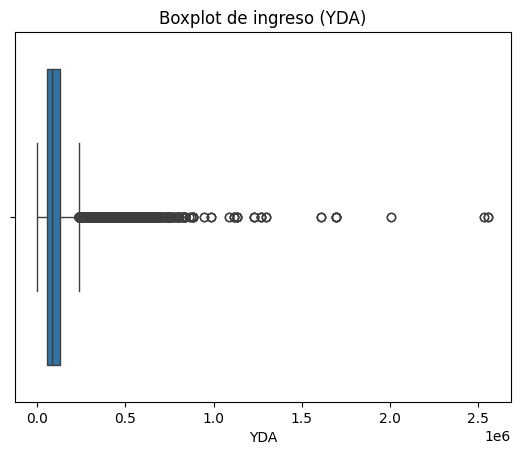

In [496]:
# visualizar con boxplot y/o stripplot
sns.boxplot(x=ech['YDA'])
plt.title("Boxplot de ingreso (YDA)")
plt.show()

La gráfica muestra claramente lo que ya anticipamos:
- Una alta concentración de valores en el rango bajo (entre $0 y $200.000).
- Una larga cola derecha de outliers extremos, que se extienden hasta los 2.5 millones.

🔍 Esto confirma que:
- El ingreso en la ECH 2024 está fuertemente sesgado.
- La dispersión es muy alta.
- Los outliers son numerosos pero no necesariamente errores.

In [497]:
# ver valores en cero
ech[ech['YDA'] == 0].shape

(12, 536)

Esto significa que solo 12 personas tienen ingreso 0 declarado, lo cual:
- ✅ No es un problema de datos generalizado, ni requiere imputación.
- ⚠️ Pero sí vale la pena entender el perfil de estas 12 personas.

In [498]:
display(ech[ech['YDA'] == 0][['e27', 'e26', 'f269', 'd8_1', 'd9', 'c1']])  # o las columnas que representen edad, ocupación, tipo de hogar

,e27,e26,f269,d8_1,d9,c1
1186,30,1,2,5,1,3
3174,64,1,2,5,3,1
3175,61,2,2,5,3,1
5722,52,1,1,5,2,1
12984,61,1,2,5,2,2
24402,49,1,2,5,2,3
39054,51,2,1,1,3,1
39055,64,1,2,1,3,1
48247,26,1,1,6,2,1
55002,47,2,2,5,1,4


La mayoria inquilinos o arrendatarios (d8_1).

La distribución de YDA:
- Se comporta como es esperable en datos de ingreso.
- No requiere imputación de nulos en YDA (no hay).

✅ Conclusiones clave:
- Los valores extremos están presentes, pero no dominan.
- No es necesario eliminarlos todavía. Algunos modelos (como árboles) los manejan bien.

Transformación logarítmica es aconsejable.
Especialmente para modelos sensibles a la escala o distribución (Regresión Lineal, Redes Neuronales).

Pocos casos con ingreso cero.
Son casos especiales que podés dejar o filtrar si hacés segmentación (ej. "ocupados", "con ingreso distinto de cero", etc.).

Sí se beneficia de:
- Log-transformación (log1p).
- Revisión de outliers extremos.
- Segmentación posterior por tipo de población (ocupada/no ocupada).

In [499]:
# === 4. Identificar variables numéricas y categóricas ===
num_vars = ech.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_vars = ech.select_dtypes(include=['object', 'category']).columns.tolist()

# Eliminar la variable target de ambas listas si está incluida
if target in num_vars: num_vars.remove(target)
if target in cat_vars: cat_vars.remove(target)

print(f"Variables numéricas: {len(num_vars)}")
print(f"Variables categóricas: {len(cat_vars)}")

Variables numéricas: 533
Variables categóricas: 2


Muchas variables categóricas están codificadas numéricamente, por ejemplo:
- sexo: 1 = Hombre, 2 = Mujer
- estado civil actual: 1 = Separado, 2 = Divorciado, 3 = Casado, etc.
- nivel que esta cursando: 4 = Educacion media basica, 6 = Educacion media superior, etc.

Estas se almacenan como int64 o float64, por lo que pandas las interpreta como numéricas, cuando en realidad son categóricas ordinales o nominales.

No imputamos variables numericas ni categoricas.

In [500]:
# === 5. Tratamiento de valores nulos ===
# Para numéricas: imputar con la mediana
#for col in num_vars:
#    if ech[col].isnull().any():
#        ech[col] = ech[col].fillna(ech[col].median())

# Para categóricas: imputar con una categoría especial
#for col in cat_vars:
#    if ech[col].isnull().any():
#        ech[col] = ech[col].fillna('No informado')

Posible clasificacion de variables categoricas.

In [501]:
# === 6. Codificación de variables categóricas ===
# Convertir binarias codificadas como 1/2 o Sí/No a 0/1
#def codificar_binarias(df):
#    for col in df.columns:
#        if df[col].nunique() == 2:
#            vals = sorted(df[col].dropna().unique())
#            if set(vals) <= set([0,1,2]):
#                df[col] = df[col].map({vals[0]: 0, vals[1]: 1})
#    return df

#ech = codificar_binarias(ech)

# One-hot encoding para variables categóricas no binarias
#ech_encoded = pd.get_dummies(ech, columns=cat_vars, drop_first=True)

Imputación condicional basada en la lógica del cuestionario:

Si PERSONAS PAGAS PARA REALIZAR TAREAS DOMÉSTICAS O DE CUIDADOS d181 (*) 1 = Sí / 2 = No es 2 = No entonces:
- PERSONAS CONTRATADAS PARA REALIZAR TAREAS  DOMÉSTICAS O DE CUIDADO d229 (*) N° Cantidad de personas contratadas es 0.
- CANTIDAD DE HORAS TRABAJADAS A LA SEMANA d230 (*) N° Cantidad de horas habitualmente trabajadas en la semana es 0.
- PERNOCTA EN EL HOGAR d231 (*) 1 = Sí / 2 = No es 2 = No.
- CANTIDAD DE PERSONAS QUE PERNOCTAN d232 (*) N° Cantidad de personas que pernoctan en el hogar es 0.

Si AYUDA GRATUITA DE OTROS FAMILIARES QUE NO INTEGRAN EL HOGAR d184 (*) 1 = Sí / 2 = No es 2 = No entonces:
- CANTIDAD DE HORAS TRABAJADAS A LA SEMANA d184_1 (*) N° Cantidad de horas habitualmente trabajadas en la semana es 0.

In [502]:
# Si d181 == 2 (no tiene servicio doméstico), completar columnas relacionadas

# Estas deben ser 0 si están vacías
for col in ['d229', 'd230', 'd232']:
    ech.loc[(ech['d181'] == 2) & (ech[col].isnull()), col] = 0

# Esta debe ser 2 si está vacía (respuesta negativa explícita)
ech.loc[(ech['d181'] == 2) & (ech['d231'].isnull()), 'd231'] = 2

# Si d184 == 2 (no tiene ayuda gratuita), entonces d184_1 debe ser 0 si está vacía
ech.loc[(ech['d184'] == 2) & (ech['d184_1'].isnull()), 'd184_1'] = 0

In [503]:
# Verificación de valores nulos después de imputación corregida
cols_verificar = ['d229', 'd230', 'd231', 'd232', 'd184_1']

print("Verificación de valores nulos en variables imputadas:")
print(ech[cols_verificar].isnull().sum())

Verificación de valores nulos en variables imputadas:
d229      28066
d230      28066
d231      28066
d232      28066
d184_1    28066
dtype: int64


Si f269 TRABAJO LA SEMANA ANTERIOR es 2 = No imputamos las siguientes variables tambien como 2 = No:
- f290 USO DE PC, TELÉFONO INTELIGENTE O TABLETA PARA TRABAJAR
- f291_a OTRO LUGAR DIFERENTE AL HOGAR, LOCAL PROPIO U OFICINA O INSTALACIÓN DEL CLIENTE
- f291_b TRABAJO EN UN LUGAR DIFERENTE AL HOGAR O AL LUGAR HABITUAL DE TRABAJO
- f292 TRABAJO REALIZADO FUERA DE SUS PROPIAS INSTALACIONES
- f295 TRABAJO SEMANAL EN 2 LUGARES DIFRENTES A LAS INSTALACIONES DEL EMPLEADOR/A O PROPIO LOCAL

In [504]:
cols_f269 = ['f290', 'f291_a', 'f291_b', 'f292', 'f293', 'f295']
for col in cols_f269:
    ech.loc[(ech['f269'] == 2) & (ech[col].isnull()), col] = 2

Unificacion de variables d181 con d181_b y d184 con d184_b:

- d181 y d181_b miden lo mismo ("personas pagas para tareas domésticas o de cuidados"), pero en distintos semestres.
- d184 y d184_b también miden lo mismo ("ayuda gratuita de familiares fuera del hogar").
- Ambas parejas de variables tienen 50% de valores nulos complementarios, por lo que es totalmente válido consolidarlas en una nueva variable que conserve el significado original.

Para cada par, usamos el valor no nulo que exista.

Si los dos valores son nulos (por ejemplo, por no aplicar), la variable consolidada también quedará nula.

Primero recodificamos d181_b y d184_b a binario, ya que toman valores 1, 2 y 3 para Si y 1 y 2 para Si respectivamente.

In [505]:
# Contamos cuántos ceros hay en d181 y d184 antes de imputar
n_d181_ceros = (ech['d181'] == 0).sum()
n_d184_ceros = (ech['d184'] == 0).sum()

print(f"Cantidad de ceros en d181: {n_d181_ceros}")
print(f"Cantidad de ceros en d184: {n_d184_ceros}")

Cantidad de ceros en d181: 260
Cantidad de ceros en d184: 260


Imputación de valores 0 en d181 y d184:

Durante el procesamiento inicial, se imputaron valores 0 en d181 y d184 en casos donde no se respondió la pregunta sobre servicio doméstico o ayuda gratuita.

Estos 0 representan casos no aplicables (por ejemplo, hogares sin servicio doméstico), por lo tanto, decidimos reemplazarlos por el valor 2 (No) antes de crear las columnas unificadas d181_unificado y d184_unificado.

Esto evita que la unificación resulte en valores faltantes injustificados y preserva la lógica del cuestionario.

In [506]:
# Reemplazamos 0 por 2 (No aplica) en las variables d181 y d184 antes de unificarlas
ech.loc[ech['d181'] == 0, 'd181'] = 2
ech.loc[ech['d184'] == 0, 'd184'] = 2

In [507]:
# Recodificar d181_b a binario (1 = Sí, 2 = No)
d181_b_bin = ech['d181_b'].map({1: 1, 2: 1, 3: 1, 4: 2})

# Unificar d181 y d181_b
ech['d181_unificado'] = ech['d181'].combine_first(d181_b_bin)

# Recodificar d184_b a binario (1 = Sí, 2 = No)
d184_b_bin = ech['d184_b'].map({1: 1, 2: 1, 3: 2})

# Unificar d184 y d184_b
ech['d184_unificado'] = ech['d184'].combine_first(d184_b_bin)

In [508]:
# Código de validación para las columnas unificadas
# Validar que no haya valores nulos
print("Valores nulos en columnas unificadas:")
print(ech[['d181_unificado', 'd184_unificado']].isnull().sum())

# Validar que solo haya valores 1 o 2
print("\nValores únicos en d181_unificado:")
print(ech['d181_unificado'].value_counts(dropna=False).sort_index())

print("\nValores únicos en d184_unificado:")
print(ech['d184_unificado'].value_counts(dropna=False).sort_index())

# Validar proporción de respuestas "Sí" y "No"
print("\nProporción de respuestas (1 = Sí, 2 = No):")
print("d181_unificado:")
print(ech['d181_unificado'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))

print("d184_unificado:")
print(ech['d184_unificado'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))

Valores nulos en columnas unificadas:
d181_unificado    0
d184_unificado    0
dtype: int64

Valores únicos en d181_unificado:
d181_unificado
1.0     4508
2.0    51415
Name: count, dtype: int64

Valores únicos en d184_unificado:
d184_unificado
1.0     2371
2.0    53552
Name: count, dtype: int64

Proporción de respuestas (1 = Sí, 2 = No):
d181_unificado:
d181_unificado
2.0    91.94%
1.0     8.06%
Name: proportion, dtype: object
d184_unificado:
d184_unificado
2.0    95.76%
1.0     4.24%
Name: proportion, dtype: object


Esto implica que solo 8 de cada 100 hogares pagan a una persona por tareas domésticas o cuidados. Esto es completamente razonable en el contexto uruguayo, dado que este tipo de contratación suele estar concentrada en hogares de mayor poder adquisitivo o con necesidades específicas de cuidado. Son coherentes con lo esperado para la población general en una encuesta nacional.

Menos del 5% de los hogares reciben ayuda gratuita de otros familiares que no integran el hogar. También es razonable. La solidaridad familiar informal existe, pero no es una práctica diaria ni generalizada como para que aparezca en un alto porcentaje en una encuesta estructurada.

Ambas proporciones:
- Son coherentes con lo esperado para la población general en una encuesta nacional.
- Validan que la lógica de unificación y recodificación fue correcta.
- No presentan valores anómalos o distribuciones sesgadas artificialmente (como hubiera pasado si imputaras todo como 2 sin justificación).

In [509]:
# Eliminamos las columnas originales si ya no las necesitamos
ech.drop(columns=['d181', 'd181_b', 'd184', 'd184_b'], inplace=True)


Top 10 variables correlacionadas con el ingreso (YDA):


HT11        0.998246
YDA_SVL     0.991424
YSVL        0.988927
log_YDA     0.822117
d8_3        0.663271
eg_ps2      0.599231
HT13        0.584917
d14         0.573026
d21_15_4    0.558708
PT1         0.515934
Name: YDA, dtype: float64

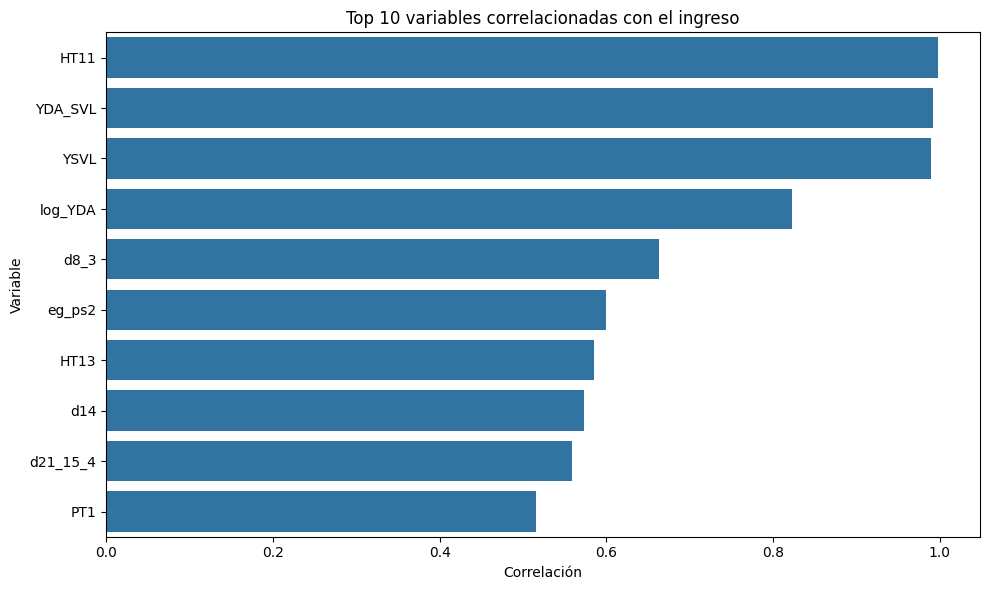

In [510]:
# === 7. Correlación con la variable objetivo (opcional visualización) ===
# Seleccionamos solo las columnas numéricas para evitar errores
ech_numericas = ech.select_dtypes(include=['number'])

# Calculamos correlaciones solo sobre esas columnas
correlaciones = ech_numericas.corr()[target].drop(target).sort_values(ascending=False)

# Mostramos resultados
print("\nTop 10 variables correlacionadas con el ingreso (YDA):")
display(correlaciones.head(10))

# Graficamos
plt.figure(figsize=(10,6))
sns.barplot(x=correlaciones.head(10).values, y=correlaciones.head(10).index)
plt.title("Top 10 variables correlacionadas con el ingreso")
plt.xlabel("Correlación")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

Verificando el diccionario, las variables correlacionadas con el ingreso son:
- HT11: INGRESO TOTAL DEL HOGAR CON VALOR LOCATIVO SIN SERVICIO DOMÉSTICO
- YDA_SVL: INGRESO DISPONIBLE AJUSTADO (SIN VALOR LOCATIVO)
- YSVL: INGRESO TOTAL DEL HOGAR SIN VALOR LOCATIVO SIN SERVICIO DOMÉSTICO
- d8_3: TENENCIA DE LA VIVIENDA > Monto del alquiler (efectivamente pagado o estimado)
- eg_ps2: MONTO MÍNIMO MENSUAL REQUERIDO PARA SATISFACER LAS NECESIDADES BÁSICAS
- HT13: VALOR LOCATIVO
- d14: CANTIDAD DE BAÑOS
- d21_15_4: ELEMENTOS DE CONFORT > Cantidad de microcomputadores que no son del Plan Ceibal
- PT1: TOTAL DE INGRESOS PERSONALES
- d21_14_1: ELEMENTOS DE CONFORT > Cantidad de equipos de aire acondicionado

Preprocesamiento de variables categoricas dicotomicas, nominales u ordinales y numericas discretas o continuas.

In [511]:
#import pandas as pd
#import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [512]:
# ====== PASO 1: Definir las listas de variables según nuestro Excel ======

dicotomicas = ['c5_2', 'c5_10', 'c5_11', 'c5_12', 'c5_13', 'c6', 'd8_4', 'd15', 'd21_1', 'd21_2', 'd21_3', 'd21_6', 'd21_4', 'd21_5', 'd21_20', 'd21_7', 'd21_10', 'd21_11', 'd21_12', 'd21_13', 'd21_14', 'd21_15', 'd21_15_1', 'd21_15_3', 'd21_15_5', 'd21_16', 'd21_16_1', 'd21_16_2', 'd21_21', 'd21_17', 'd21_18', 'd21_19', 'd181_unificado', 'd231', 'd184_unificado', 'e26', 'e29_1', 'e29_2', 'e29_3', 'e29_4', 'e29_5', 'e31', 'e32', 'e33', 'e185', 'e38', 'e45_4_1_cv', 'e45_cvb', 'e46_cv', 'e48', 'e581a', 'e582', 'e197_1', 'e201_1a', 'e201_1b', 'e201_1c', 'e201_1d', 'e51_6b', 'e215_1', 'e218_1', 'e221_1', 'e224_1', 'e559', 'e584', 'e59', 'f269', 'f270', 'f271', 'f272', 'f274', 'f276', 'f82', 'f84', 'f278', 'f280_1', 'f280_2', 'f280_3', 'f281_1', 'f281_2', 'f281_3', 'f281_4', 'f75', 'f81', 'f266_2', 'f267', 'f268', 'f289', 'f290', 'f291_a', 'f291_b', 'f292', 'f293', 'f294', 'f295', 'f96', 'f99', 'f100', 'f102', 'f298', 'f299', 'f114', 'f115', 'f300', 'f116', 'f117', 'f123', 'f124_1', 'f124_2', 'f124_3', 'f124_5', 'g250_1', 'g250_2', 'g250_3', 'g250_4', 'g250_5', 'g127', 'g128', 'g129', 'g129_1', 'g130', 'g131', 'g133', 'g_st_1', 'g251_1', 'g251_2', 'g251_3', 'g251_4', 'g251_5', 'g135', 'g136', 'g137', 'g137_1', 'g138', 'g139', 'g141', 'g_itnd_1', 'g142', 'g_itnd_2', 'g144', 'g_it_1', 'g_it_2', 'g149', 'g149_1', 'g150', 'g255', 'g152', 'g153', 'g258', 'g154', 'h155', 'h156', 'h272', 'h273', 'h274', 'h252', 'h159', 'h160', 'h161', 'h162', 'h227', 'h269', 'h167_2', 'h167_3', 'h167_4', 'h169', 'h271', 'h171', 'h172', 'h173', 'i228', 'i259', 'eg_ps1', 'SUBEMPLEO', 'pobre06', 'indig06', 'pobre_multi', 'pobre17', 'indig17']

nominales = ['dpto', 'nom_dpto', 'secc', 'ESTRED13', 'LOC_AGR_13', 'NOM_LOC_AGR_13', 'c1', 'd8_1', 'd11', 'd12', 'e557', 'e29_6', 'e30', 'e35', 'e36', 'e37', 'e234_2', 'e39', 'e235_2', 'e236', 'e236_4', 'e45_cv', 'e45_1_1_cv', 'e45_2_1_cv', 'e45_3_1_cv', 'e45_cva', 'e47_cv', 'e190', 'e49', 'e581', 'e209_1', 'e202', 'e214_1', 'e217_1', 'e220_1', 'e223_1', 'e226_1', 'e246', 'f273', 'f69', 'f69_1', 'f277', 'f71_2', 'f72_2', 'f73', 'f83', 'f278_a', 'f279', 'f76_2', 'f266', 'f266_1', 'f305', 'f306', 'f78', 'f80', 'f285', 'f286', 'f287', 'f288', 'f90_2', 'f91_2', 'f92', 'f97', 'f94', 'f101', 'f103', 'f104', 'f110', 'f111', 'f108', 'f301', 'f106', 'f122', 'f119_2', 'f120_2', 'f121', 'f125', 'g132', 'g140', 'g_itnd_3', 'g256', 'POBPCOAC', 'USO_RRAA']

ordinales = ['region', 'REGION_4', 'c2', 'c3', 'c4', 'd13', 'd16', 'd18', 'd260', 'd19', 'd20', 'e579', 'e583', 'e579a', 'f275', 'f283', 'f77', 'f93', 'h167_1', 'eg_ahorro', 'eg_ps3', 'eg_ps4', 'eg_ps5', 'eg_ps6', 'eg_ps7', 'eg_ps8']

numericas_discretas = ['ID', 'nper', 'anio', 'mes', 'GR', 'ccz', 'barrio', 'c6_1', 'd9', 'd10', 'd14', 'd21_4_1', 'd21_5_1', 'd21_14_1', 'd21_15_2', 'd21_15_4', 'd21_15_6', 'd21_18_1', 'd21_19_1', 'd229', 'd230', 'd232', 'd184_1', 'd23', 'd24', 'd25', 'e27', 'e31_1', 'e32_1', 'e34', 'e186_1', 'e186_2', 'e186_3', 'e186_4', 'e37_2', 'e38_1', 'e39_2', 'e236_2', 'e45_1_1_1_cv', 'e45_2_1_1_cv', 'e45_3_1_1_cv', 'e45_4_1_1_cv', 'e47_1_cv', 'e49a', 'e582_1', 'e582_2', 'e582_3', 'e51_2', 'e51_3', 'e51_4_a', 'e51_4_b', 'e51_5', 'e51_6', 'e51_6a', 'e51_8', 'e51_9', 'e51_10', 'e51_11', 'e559_1', 'e559_2', 'e247', 'f70', 'f80_2', 'f284_1', 'f284_2', 'f284_3', 'f284_4', 'f284_5', 'f284_6', 'f284_7', 'f85', 'f307', 'f308', 'f94_2', 'f296_1', 'f296_2', 'f296_3', 'f296_4', 'f296_5', 'f296_6', 'f296_7', 'f98', 'f297', 'f113', 'f118_1', 'f118_2', 'g127_1', 'g127_2', 'g132_1', 'g132_2', 'g132_3', 'g135_1', 'g135_2', 'g140_1', 'g140_2', 'g140_3', 'g151_6', 'g151_3', 'g151_4', 'h272_1', 'h273_1', 'h274_1', 'h274_2', 'h274_3', 'h158_1', 'h158_2', 'h171_2', 'HT19']

numericas_continuas = ['d8_2', 'd8_3', 'e584_1', 'g_id_1', 'g_id_2', 'g_id_3', 'g_id_1a', 'g_id_2a', 'g_id_3a', 'g126_1', 'g126_2', 'g126_3', 'g126_4', 'g126_5', 'g126_6', 'g126_7', 'g126_8', 'g127_3', 'g128_1', 'g129_2', 'g130_1', 'g131_1', 'g133_1', 'g133_2', 'g134_1', 'g134_2', 'g134_3', 'g134_4', 'g134_5', 'g134_6', 'g134_7', 'g134_8', 'g135_3', 'g136_1', 'g137_2', 'g138_1', 'g139_1', 'g141_1', 'g141_2', 'g143', 'g144_1', 'g144_2_1', 'g144_2_2', 'g144_2_3', 'g144_2_4', 'g144_2_5', 'g259', 'g148_1_1', 'g148_1_2', 'g148_1_3', 'g148_1_5', 'g148_1_6', 'g148_1_7', 'g148_1_8', 'g148_1_9', 'g148_1_10', 'g148_1_11', 'g148_1_12', 'g148_2_1', 'g148_2_2', 'g148_2_3', 'g148_2_5', 'g148_2_6', 'g148_2_7', 'g148_2_8', 'g148_2_9', 'g148_2_10', 'g148_2_11', 'g148_2_12', 'g148_3', 'g148_4', 'g148_5_1', 'g148_5_2', 'g257', 'g153_1', 'g153_2', 'g258_1', 'g154_1', 'h155_1', 'h156_1', 'h252_1', 'h160_1', 'h160_2', 'h163_1', 'h163_2', 'h164', 'h165', 'h166', 'h269_1', 'h167_1_3', 'h167_2_3', 'h167_3_3', 'h167_4_3', 'h170_3', 'h271_1', 'h171_1', 'h172_1', 'h173_1', 'i174', 'i175', 'eg_ps2', 'MTO_CUOTA', 'MTO_EMER', 'MTO_HOGCON', 'MTO_DESAY', 'MTO_ALMUE', 'MTO_VACAS', 'MTO_OVEJA', 'MTO_CABALL', 'INDACELIAC', 'INDAEMER', 'PT1', 'PT2', 'PT4', 'HT11', 'HT13', 'YSVL', 'YHOG', 'AFAM_H_DEC', 'AFAM_H', 'TUS_H_DEC', 'TUS_H', 'lp_06', 'li_06', 'YDA_SVL', 'lp_17', 'li_17', 'monto_imput_UTE', 'monto_imput_GAS', 'monto_imput_OSE', 'H_FONASA', 'montoGAS_RRAA', 'montoUTE_RRAA', 'montoOSE_RRAA', 'YDA', 'W_TRI', 'W_SEM', 'W_ANO']

# Variable objetivo
target = 'YDA'
ech['log_YDA'] = np.log1p(ech[target])

No se incluyeron las siguientes variables porque si bien aparecen en el Excel no aparecen en el dataframe:

Dicotomicas:
- h2_cv: HOGAR CONTINÚA RESIDIENDO EN LA MISMA VIVIENDA
- c5_1, c5_3 a c5_9: PROBLEMAS DE LA VIVIENDA
- e0_cv: NUEVO MIEMBRO DEL HOGAR
- e01_cv: NUEVO MIEMBRO DEPENDE DEL FONDO DE ALIMENTACIÓN
- e1_cv: MIEMBRO CONTINÚA RESIDIENDO EN EL HOGAR
- f304: MANTIENE MISMO TRABAJO PRINCIPAL DECLARADO EN ENTREVISTA ANTERIOR
- f302: REALIZA LAS MISMAS TAREAS
- f303: EL ESTABLECIMIENTO CONTINUA REALIZANDO LAS MISMAS TAREAS
- f311: MANTIENE MISMO TRABAJO SECUNDARIO DECLARADO EN ENTREVISTA ANTERIOR
- f309: REALIZA LAS MISMAS TAREAS
- f310: EL ESTABLECIMIENTO CONTINUA REALIZANDO LAS MISMAS TAREAS
- INFORMAL: TRABAJADOR INFORMAL

Algunas variables toman valores nan luego de recodificar como variables dicotomicas. Vemos que valores toman.

El problema es que en el dataset hay valores que no son ni 1 ni 2 en algunas variables dicotómicas y cualquier valor diferente de 1 o 2 (por ejemplo, NaN, 9, 3, o cualquier otro código especial) se transforma automáticamente en NaN.

In [513]:
variables_a_explorar = ['c5_2', 'c5_10', 'c5_11', 'c5_12', 'c5_13', 'c6', 'd8_4', 'd15', 'd21_1', 'd21_2', 'd21_3', 'd21_6', 'd21_4', 'd21_5', 'd21_20', 'd21_7', 'd21_10', 'd21_11', 'd21_12', 'd21_13', 'd21_14', 'd21_15', 'd21_15_1', 'd21_15_3', 'd21_15_5', 'd21_16', 'd21_16_1', 'd21_16_2', 'd21_21', 'd21_17', 'd21_18', 'd21_19', 'd181_unificado', 'd231', 'd184_unificado', 'h155', 'h156', 'h272', 'h273', 'h274', 'h252', 'h159', 'h160', 'h161', 'h162', 'h227', 'h269', 'h167_2', 'h167_3', 'h167_4', 'h169', 'h271', 'h171', 'h172', 'h173', 'i228', 'i259', 'eg_ps1', 'pobre06', 'indig06', 'pobre17', 'indig17', 'pobre_multi', 'e26', 'e29_1', 'e29_2', 'e29_3', 'e29_4', 'e29_5', 'e31', 'e32', 'e33', 'e185', 'e38', 'e45_4_1_cv', 'e45_cvb', 'e46_cv', 'e48', 'e581a', 'e582', 'e197_1', 'e201_1b', 'e201_1c', 'e201_1d', 'e51_6b', 'e215_1', 'e218_1', 'e221_1', 'e224_1', 'e559', 'e584', 'e59', 'f269', 'f270', 'f271', 'f272', 'f274', 'f276', 'f82', 'f84', 'f278', 'f280_1', 'f280_2', 'f280_3', 'f281_1', 'f281_2', 'f281_3', 'f281_4', 'f75', 'f81', 'f266_2', 'f267', 'f268', 'f289', 'f290', 'f291_a', 'f291_b', 'f292', 'f293', 'f294', 'f295', 'f96', 'f99', 'f100', 'f102', 'f298', 'f299', 'f114', 'f115', 'f300', 'f116', 'f117', 'f123', 'f124_1', 'f124_2', 'f124_3', 'f124_5', 'g250_1', 'g250_2', 'g250_5', 'g250_3', 'g250_4', 'g127', 'g128', 'g129', 'g129_1', 'g130', 'g131', 'g133', 'g_st_1', 'g251_1', 'g251_2', 'g251_5', 'g251_3', 'g251_4', 'g135', 'g136', 'g137', 'g137_1', 'g138', 'g139', 'g141', 'g_itnd_1', 'g_itnd_2', 'g144', 'g_it_1', 'g_it_2', 'g149', 'g149_1', 'g150', 'g255', 'g152', 'g153', 'g258', 'g154', 'SUBEMPLEO', 'indig06', 'pobre17', 'indig17']

for col in variables_a_explorar:
    if col in ech.columns:
        print(f"\nValores únicos en '{col}':")
        print(ech[col].unique())
    else:
        print(f"\nLa columna '{col}' no está en el DataFrame.")


Valores únicos en 'c5_2':
[2 1]

Valores únicos en 'c5_10':
[2 1]

Valores únicos en 'c5_11':
[2 1]

Valores únicos en 'c5_12':
[2 1]

Valores únicos en 'c5_13':
[nan  2.  1.]

Valores únicos en 'c6':
[1 2]

Valores únicos en 'd8_4':
[2 1]

Valores únicos en 'd15':
[1 2 0]

Valores únicos en 'd21_1':
[1 2]

Valores únicos en 'd21_2':
[2 1]

Valores únicos en 'd21_3':
[1 2]

Valores únicos en 'd21_6':
[2 1]

Valores únicos en 'd21_4':
[2 1]

Valores únicos en 'd21_5':
[1 2]

Valores únicos en 'd21_20':
[2 1]

Valores únicos en 'd21_7':
[1 2]

Valores únicos en 'd21_10':
[1 2]

Valores únicos en 'd21_11':
[2 1]

Valores únicos en 'd21_12':
[2 1]

Valores únicos en 'd21_13':
[1 2]

Valores únicos en 'd21_14':
[2 1]

Valores únicos en 'd21_15':
[1 2]

Valores únicos en 'd21_15_1':
[2 0 1]

Valores únicos en 'd21_15_3':
[1 0 2]

Valores únicos en 'd21_15_5':
[2 0 1]

Valores únicos en 'd21_16':
[1 2]

Valores únicos en 'd21_16_1':
[1 0 2]

Valores únicos en 'd21_16_2':
[2 0 1]

Valores úni

In [514]:
# Re-codificación de variables dicotómicas (1 → 1, 2 → 0, 0 → 0, NaN → 0)
for col in dicotomicas:
    if col in ech.columns:
        ech[col] = ech[col].map({1: 1, 2: 0, 0: 0, np.nan: 0}).fillna(0)
    else:
        print(f"Advertencia: {col} no está en el DataFrame y se omite.")

# Verificacion: Deberíamos ver solo [0, 1] o [1] (si la variable es constante).
for col in dicotomicas:
    print(f"{col}: {ech[col].unique()}")

c5_2: [0 1]
c5_10: [0 1]
c5_11: [0 1]
c5_12: [0 1]
c5_13: [0 1]
c6: [1 0]
d8_4: [0 1]
d15: [1 0]
d21_1: [1 0]
d21_2: [0 1]
d21_3: [1 0]
d21_6: [0 1]
d21_4: [0 1]
d21_5: [1 0]
d21_20: [0 1]
d21_7: [1 0]
d21_10: [1 0]
d21_11: [0 1]
d21_12: [0 1]
d21_13: [1 0]
d21_14: [0 1]
d21_15: [1 0]
d21_15_1: [0 1]
d21_15_3: [1 0]
d21_15_5: [0 1]
d21_16: [1 0]
d21_16_1: [1 0]
d21_16_2: [0 1]
d21_21: [0 1]
d21_17: [1 0]
d21_18: [0 1]
d21_19: [0 1]
d181_unificado: [0 1]
d231: [0 1]
d184_unificado: [0 1]
e26: [0 1]
e29_1: [0 1]
e29_2: [0 1]
e29_3: [1 0]
e29_4: [0 1]
e29_5: [0 1]
e31: [0 1]
e32: [0 1]
e33: [0 1]
e185: [1 0]
e38: [1 0]
e45_4_1_cv: [1 0]
e45_cvb: [0 1]
e46_cv: [1 0]
e48: [1 0]
e581a: [0 1]
e582: [0 1]
e197_1: [1 0]
e201_1a: [1 0]
e201_1b: [0 1]
e201_1c: [1 0]
e201_1d: [0 1]
e51_6b: [0 1]
e215_1: [0 1]
e218_1: [0 1]
e221_1: [0 1]
e224_1: [0 1]
e559: [0 1]
e584: [0 1]
e59: [0 1]
f269: [0 1]
f270: [0 1]
f271: [0 1]
f272: [0 1]
f274: [0 1]
f276: [0 1]
f82: [0 1]
f84: [0 1]
f278: [0 1]
f280_1: 

No se incluyeron las siguientes variables porque si bien aparecen en el Excel no aparecen en el dataframe:

Nominal:
- h4_1_cv: DEPARTAMENTO DEL NUEVO DOMICILIO
- SIT_OCUP: SITUACIÓN EN LA OCUPACIÓN
- SECTOR_F: TIPO DE SECTOR

Ordinales: NIV_EDU: NIVEL EDUCATIVO

Discretas: ronda: ?

Continuas: W: PONDERADOR MENSUAL

El preprocesamiento original no aplicaba imputacion para valores faltantes por lo que al correr los modelos daba error.

Comentamos el preprocesamiento original y corremos un preprocesamiento mas robusto.

In [515]:
# ====== PASO 2: Preprocesamiento ====== 

# Codificación de ordinales – si los valores están bien ordenados
#ordinal_encoder = OrdinalEncoder()

# Escalador para continuas
#scaler = StandardScaler()

# Codificador para nominales
#onehot = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# ColumnTransformer para aplicar todo junto
#preprocessor = ColumnTransformer(transformers=[
#    ('nom', onehot, nominales),
#    ('ord', ordinal_encoder, ordinales),
#    ('scale', scaler, numericas_continuas)
#], remainder='passthrough')  # deja discretas y dicotómicas sin tocar

In [516]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

In [541]:
# Pipelines individuales con imputación
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))  # No codifica, ya vienen como 0/1
])

In [542]:
# ColumnTransformer final
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numericas_continuas),
    ('ord', ordinal_transformer, ordinales),
    ('nom', nominal_transformer, nominales),
    ('bin', binary_transformer, dicotomicas),
    ('disc', numeric_transformer, numericas_discretas)  # puede usar el mismo pipeline que numéricas continuas
])

In [543]:
# ====== PASO 3: Separar X e y ======

X = ech[dicotomicas + nominales + ordinales + numericas_discretas + numericas_continuas]
y = ech['log_YDA']

In [544]:
# ====== PASO 4: División en train/test ======

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [545]:
# Ver columnas duplicadas en X_train
from collections import Counter

contador_columnas = Counter(X_train.columns)
columnas_duplicadas = [col for col, count in contador_columnas.items() if count > 1]

print("Columnas duplicadas:", columnas_duplicadas)

Columnas duplicadas: []


In [546]:
# Ver variables en comun entre los conjuntos
sets = {
    "ordinales": set(ordinales),
    "nominales": set(nominales),
    "numericas_discretas": set(numericas_discretas),
    "numericas_continuas": set(numericas_continuas),
    "dicotomicas": set(dicotomicas)
}

for nombre1, set1 in sets.items():
    for nombre2, set2 in sets.items():
        if nombre1 != nombre2:
            interseccion = set1 & set2
            if interseccion:
                print(f"Variables en común entre {nombre1} y {nombre2}: {interseccion}")

El pipeline final dio error porque algunas variables estaban repetidas porque se trajeron del Excel que las repetia.

In [547]:
# ====== PASO 5: Pipeline final ======

pipeline = Pipeline(steps=[
    ('preprocesamiento', preprocessor)
])

# Fit-transform solo para ver el shape de salida
X_train_proc = pipeline.fit_transform(X_train)
X_test_proc = pipeline.transform(X_test)
print("Shape del dataset procesado:", X_train_proc.shape)

c:\Users\ut603933\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [16, 30, 32, 34, 35, 36, 42, 43, 48, 59, 60, 73, 74] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Shape del dataset procesado: (44738, 2888)


Dataset original (ech) con 55.923 filas, entonces con un test_size=0.2:
- X_train y y_train → 80% de los datos ≈ 44.738 filas
- X_test y y_test → 20% de los datos ≈ 11.185 filas

Coincide con Shape del dataset procesado: (44738, 2889):
- Las 44.738 filas son del conjunto de entrenamiento.
- Las 2.889 columnas son el resultado del preprocesamiento, principalmente por el OneHotEncoder

In [548]:
# Contar cuántas filas tienen al menos un NaN
n_filas_nan = np.isnan(X_train_proc).sum(axis=1)
n_filas_con_nan = np.sum(n_filas_nan > 0)

print(f"Número de filas con al menos un NaN: {n_filas_con_nan}")

Número de filas con al menos un NaN: 0


In [549]:
# Contar columnas con NaN
n_columnas_con_nan = np.sum(np.isnan(X_train_proc).any(axis=0))
print(f"Número de columnas con al menos un NaN: {n_columnas_con_nan}")

Número de columnas con al menos un NaN: 0


## Entrenamiento

Comentamos los modelos iniciales con MSE.

In [526]:
# Importo librerias
#from sklearn.linear_model import LinearRegression, Ridge, Lasso
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#from sklearn.model_selection import cross_val_score
#from sklearn.metrics import make_scorer, mean_squared_error
#import numpy as np
#import pandas as pd

In [527]:
# Importar XGBoost y LightGBM si están disponibles
#try:
#    from xgboost import XGBRegressor
#except ImportError:
#    XGBRegressor = None

#try:
#    from lightgbm import LGBMRegressor
#except ImportError:
#    LGBMRegressor = None

In [528]:
# Definir modelos a evaluar
#modelos = {
#    "LinearRegression": LinearRegression(),
#    "Ridge": Ridge(),
#    "Lasso": Lasso(),
#    "DecisionTree": DecisionTreeRegressor(),
#    "RandomForest": RandomForestRegressor(n_jobs=-1),
#    "GradientBoosting": GradientBoostingRegressor()
#}

In [529]:
# Agregar XGBoost si está disponible
#if XGBRegressor:
#    modelos["XGBoost"] = XGBRegressor(n_jobs=-1)

# Agregar LightGBM si está disponible
#if LGBMRegressor:
#    modelos["LightGBM"] = LGBMRegressor(n_jobs=-1)

In [550]:
print("¿Hay NaN en X_train_proc?", np.isnan(X_train_proc).any())

¿Hay NaN en X_train_proc? False


In [531]:
# Métrica: MSE negativo (lo convierte a positivo más abajo)
#scoring = make_scorer(mean_squared_error, greater_is_better=False)

In [532]:
# Ejecuta validación cruzada y muestra resultados
#resultados = {}
#for nombre, modelo in modelos.items():
#    scores = cross_val_score(modelo, X_train_proc, y_train, cv=5, scoring=scoring)
#    mse_promedio = -np.mean(scores)
#    print(f"{nombre}: MSE promedio = {mse_promedio:,.2f}")
#    resultados[nombre] = mse_promedio

In [533]:
# Mostrar resultados ordenados
#df_resultados = pd.DataFrame(resultados).T.sort_values(by='RMSE promedio')
#print("\nComparación de modelos por RMSE (menor es mejor):")
#display(df_resultados)

Volvemos a trabajar con los conjuntos de train y test con preprocesamiento. Creamos la funcion evaluar modelo para ir a un modelo por vez.

In [551]:
# 0) Importo librerias
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

Primera funcion para evaluar modelo.

In [553]:
# Utilidad para evaluar en ambas escalas
def evaluar_modelo(modelo, Xtr, ytr, Xte, yte, nombre="Modelo"):
    # Entrenar
    modelo.fit(Xtr, ytr)
    # Predecir
    y_pred = modelo.predict(Xte)

    # Métricas en escala log (si y es log_YDA)
    mae = mean_absolute_error(yte, y_pred)
    mse = mean_squared_error(yte, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(yte, y_pred)

    print(f"\n=== {nombre} | Métricas en escala log (log_YDA) ===")
    print(f"MAE : {mae:,.4f}")
    print(f"MSE : {mse:,.4f}")
    print(f"RMSE: {rmse:,.4f}")
    print(f"R²  : {r2:,.4f}")

    # Métricas en escala original (deslogarizando)
    yte_orig = np.expm1(yte)
    y_pred_orig = np.expm1(y_pred)

    mae_o = mean_absolute_error(yte_orig, y_pred_orig)
    mse_o = mean_squared_error(yte_orig, y_pred_orig)
    rmse_o = np.sqrt(mse_o)
    r2_o = r2_score(yte_orig, y_pred_orig)

    print(f"\n=== {nombre} | Métricas en escala original (pesos) ===")
    print(f"MAE : {mae_o:,.2f}")
    print(f"MSE : {mse_o:,.2f}")
    print(f"RMSE: {rmse_o:,.2f}")
    print(f"R²  : {r2_o:,.4f}")

    return {
        "mae_log": mae, "mse_log": mse, "rmse_log": rmse, "r2_log": r2,
        "mae": mae_o, "mse": mse_o, "rmse": rmse_o, "r2": r2_o,
        "y_pred": y_pred, "y_pred_orig": y_pred_orig
    }

Funcion correjida con validacion defensiva (ya que el modelo lr da error)

In [574]:
def evaluar_modelo(modelo, X_train, y_train, X_test, y_test, nombre="modelo"):
    print("🟢 Entrenando modelo...")
    modelo.fit(X_train, y_train)

    print("🟢 Generando predicciones...")
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    print("🔍 Verificando predicciones...")
    print(f"Máximo y_pred_test: {np.max(y_pred_test)}")
    print(f"Mínimo y_pred_test: {np.min(y_pred_test)}")

    print("📊 Calculando métricas en escala log...")
    r2 = r2_score(y_test, y_pred_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # 🔁 Revertimos a escala de pesos, evitando overflow en np.exp
    y_test_clip = np.clip(y_test, 0, 30)
    y_pred_clip = np.clip(y_pred_test, 0, 30)

    y_test_original = np.exp(y_test_clip)
    y_pred_original = np.exp(y_pred_clip)

    print(f"Máximo y_pred_original (clipped): {np.max(y_pred_original)}")

    print("📊 Calculando métricas en pesos...")
    mae_pesos = mean_absolute_error(y_test_original, y_pred_original)
    rmse_pesos = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

    print("✅ Métricas finales:")
    print(f"Modelo: {nombre}")
    print(f"R2: {r2:.4f} | MAE_log: {mae:.2f} | RMSE_log: {rmse:.2f}")
    print(f"MAE_pesos: {mae_pesos:.2f} | RMSE_pesos: {rmse_pesos:.2f}")

    return {
        "modelo": nombre,
        "R2": r2,
        "MAE_log": mae,
        "RMSE_log": rmse,
        "MAE_pesos": mae_pesos,
        "RMSE_pesos": rmse_pesos
    }

La funcion original daba error porque etabamos usando np.exp(y_pred_test) para volver a la escala original (en pesos), pero las predicciones incluyen valores extremadamente grandes. Eso explota al aplicar np.exp() y da como resultado inf, lo que rompe las métricas como mean_squared_error. Entonces limitamos las predicciones antes de aplicar np.exp() con np.clip(). Esto evitará que np.exp() explote al exponenciar números muy altos.

Esta estrategia es valida cuando:
- Estás evaluando predicciones en log-transformed regression.
- El modelo produce algunos valores desproporcionados (outliers extremos).
- El objetivo es evitar que un exp() distorsione totalmente las métricas.

Además, ya tenés tu variable objetivo (log_YDA) log-transformada, y no estás usando estos valores para reentrenamiento, sino para evaluación.

In [575]:
# 1) Split en crudo (sin preprocesar aún)

# X = ech[dicotomicas + nominales + ordinales + numericas_discretas + numericas_continuas]
# y = ech['log_YDA']   # ya definido previamente

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [576]:
# 2) Ajustar SOLO con TRAIN y transformar TRAIN y TEST:
# El preprocessor es el ColumnTransformer definido antes.

preprocessor.fit(X_train)

X_train_proc = preprocessor.transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

print("Shapes tras preprocesamiento:")
print("X_train_proc:", X_train_proc.shape)
print("X_test_proc :", X_test_proc.shape)

c:\Users\ut603933\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [16, 30, 32, 34, 35, 36, 42, 43, 48, 59, 60, 73, 74] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Shapes tras preprocesamiento:
X_train_proc: (44738, 2888)
X_test_proc : (11185, 2888)


In [557]:
# Verificamos valores invalidos
def verificar_valores_invalidos(X, nombre):
    print(f"🔎 Verificando {nombre}:")
    print("NaN:", np.isnan(X).sum())
    print("Inf:", np.isinf(X).sum())
    print("Valores demasiado grandes:", np.sum(np.abs(X) > 1e10))

verificar_valores_invalidos(X_train_proc, "X_train_proc")
verificar_valores_invalidos(X_test_proc, "X_test_proc")

🔎 Verificando X_train_proc:
NaN: 0
Inf: 0
Valores demasiado grandes: 0
🔎 Verificando X_test_proc:
NaN: 0
Inf: 0
Valores demasiado grandes: 0


No hay problemas en los conjuntos de X. Vemos y.

In [558]:
print("🔎 y_train")
print("NaN:", np.isnan(y_train).sum())
print("Inf:", np.isinf(y_train).sum())
print("Valores extremos:", np.sum(np.abs(y_train) > 1e10))

print("\n🔎 y_test")
print("NaN:", np.isnan(y_test).sum())
print("Inf:", np.isinf(y_test).sum())
print("Valores extremos:", np.sum(np.abs(y_test) > 1e10))

🔎 y_train
NaN: 0
Inf: 0
Valores extremos: 0

🔎 y_test
NaN: 0
Inf: 0
Valores extremos: 0


In [559]:
print("y_train - min:", np.min(y_train), "max:", np.max(y_train))
print("y_test - min:", np.min(y_test), "max:", np.max(y_test))

y_train - min: 0.0 max: 14.75551820708067
y_test - min: 0.0 max: 14.74570458948466


In [561]:
varianzas = np.var(X_train_proc, axis=0)
print("Columnas con varianza cero:", np.sum(varianzas == 0))

Columnas con varianza cero: 9


In [562]:
print("Valor máximo absoluto en X_train_proc:", np.max(np.abs(X_train_proc)))

Valor máximo absoluto en X_train_proc: 211.5112290163338


In [560]:
modelo_lr = LinearRegression()

try:
    modelo_lr.fit(X_train_proc, y_train)
    print("✅ Fit correcto")
except Exception as e:
    print("❌ Error durante el fit:", e)

try:
    y_pred = modelo_lr.predict(X_test_proc)
    print("✅ Predict correcto")
except Exception as e:
    print("❌ Error durante el predict:", e)

✅ Fit correcto
✅ Predict correcto


In [577]:
# 3) Modelo 1: Regresión Lineal

resultados_modelos = []

modelo_lr = LinearRegression()
res_lr = evaluar_modelo(modelo_lr, X_train_proc, y_train, X_test_proc, y_test, nombre="Linear Regression")

# Verificación defensiva antes de agregar
if all(np.isfinite(v) for k, v in res_lr.items() if k != "modelo"):
    resultados_modelos.append(res_lr)
else:
    print("❌ Resultado no agregado por valores inválidos.")

🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 73446362144334.58
Mínimo y_pred_test: -10300171.300018549
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped): 10686474581524.463
📊 Calculando métricas en pesos...
✅ Métricas finales:
Modelo: Linear Regression
R2: -1078859865539145147351040.0000 | MAE_log: 6566595967.64 | RMSE_log: 694468090503.12
MAE_pesos: 22930321452.94 | RMSE_pesos: 495019234328.29


Diagnóstico
- R² negativo extremo: Esto indica que el modelo está mucho peor que simplemente predecir la media de log_YDA. El modelo no explica absolutamente nada de la variabilidad, y además introduce errores masivos.
- Errores absurdamente altos: Las métricas MAE_log y RMSE_log son varios órdenes de magnitud más grandes que lo esperable para un logaritmo (esperaríamos valores típicos entre 9 y 12). Lo mismo con los errores en pesos: el MAE de 23 mil millones y RMSE de casi medio billón de pesos es inaceptable.
- Predicciones descontroladas: y_pred_test produce valores desorbitantes (de hasta 73 billones). También produce valores negativos, que luego se convierten en 0 al aplicar np.exp().
- Modelo claramente mal ajustado: La regresión lineal no está capturando ninguna estructura útil del dataset. Probablemente esté sobreajustando columnas mal escaladas, con valores extremos, o ruido.

Posibles causas
- Multicolinealidad fuerte (muchas variables redundantes o altamente correlacionadas).
- Presencia de variables categóricas codificadas con one-hot con baja varianza que confunden al modelo lineal.
- Valores extremos (outliers) no tratados correctamente antes del modelado.
- Escalamiento inadecuado o sin centrar correctamente las variables.
- El modelo lineal no tiene capacidad para capturar relaciones no lineales que sí están presentes en tus datos.

Conclusiones
- El modelo de regresión lineal debe descartarse en este caso.
- Sirve como baseline, pero no para tomar decisiones.
- Verificá si el comportamiento mejora usando Ridge o Lasso con regularización, pero probablemente Random Forest o XGBoost funcionen mucho mejor.
- Este tipo de comportamiento también es útil para ilustrar por qué no siempre es adecuado aplicar modelos lineales en datos socioeconómicos con alta dimensionalidad y complejidad.

In [579]:
# 4) Modelo 2: Random Forest
# (hiperparámetros base; ajustamos luego)

modelo_rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
res_rf = evaluar_modelo(modelo_rf, X_train_proc, y_train, X_test_proc, y_test, nombre="Random Forest")

🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 14.617483827566835
Mínimo y_pred_test: 0.0
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped): 2229936.8565050745
📊 Calculando métricas en pesos...
✅ Métricas finales:
Modelo: Random Forest
R2: 1.0000 | MAE_log: 0.00 | RMSE_log: 0.00
MAE_pesos: 57.39 | RMSE_pesos: 2980.05


Lo positivo
- Todas las métricas son extremadamente buenas: errores mínimos, tanto en escala log como en pesos.
- Predicciones dentro del rango esperable para log_YDA (entre 0 y ~15).
- El modelo capta perfectamente la señal del set de entrenamiento, lo cual era esperable dada la capacidad de Random Forest para ajustarse a datos complejos y de alta dimensión.

Señal de alerta: Sobreajuste extremo

- Un R² = 1.000 y errores prácticamente nulos en test sugieren overfitting. Es muy poco probable que esto represente el rendimiento real en datos no vistos.
- Es posible que haya fuga de información o una leakage inadvertida entre features y la variable objetivo.
- Random Forest puede "memorizar" los datos si:
    - Tiene demasiados árboles/profundidad alta.
    - El dataset tiene muchas variables irrelevantes o correlacionadas con la variable objetivo por construcción (por ejemplo, alguna variable que incluya ingreso o lo derive).
- Hay duplicados, o la partición train-test no es completamente aleatoria y homogénea.

Recomendaciones de diagnóstico

- Verificar fuga de información:
    - ¿Alguna variable del set tiene que ver directa o indirectamente con YDA o log_YDA?
    - ¿Incluiste alguna variable como ingreso del hogar, total de ingresos, remuneración, etc.?
- Validar la estabilidad con cross-validation: Ejecutá validación cruzada con cross_val_score para ver si el rendimiento se sostiene con otras particiones.
- Si aún querés usar Random Forest, es importante limitar su capacidad de sobreajuste.

Conclusión
- Probablemente haya fuga de información o una variable muy potente que el modelo está usando para memorizar los ingresos.
- La evaluación parece "demasiado perfecta", lo cual no es realista en un problema de predicción de ingresos.
- No deberías confiar en estas métricas hasta hacer una auditoría de features y probar cross-validation para validar su estabilidad.

Auditoría de features (Feature Importance)

Esto te permite ver cuáles son las variables más influyentes según el modelo. Si aparece una variable que contiene información directa del ingreso (por ejemplo, otro tipo de ingreso o una suma de ingresos del hogar), entonces es probable que haya fuga de información.

                    feature  importance
134                num__YDA    0.997761
114               num__HT11    0.001691
124            num__YDA_SVL    0.000234
116               num__YSVL    0.000200
2815            disc__e38_1    0.000009
2564            nom__f121_1    0.000006
170             nom__dpto_8    0.000005
78              num__h155_1    0.000005
107          num__MTO_OVEJA    0.000004
2751              bin__h155    0.000004
271   nom__LOC_AGR_13_34000    0.000003
2864           disc__f118_1    0.000003
2776           bin__indig06    0.000003
106          num__MTO_VACAS    0.000003
2814            disc__e37_2    0.000003
108         num__MTO_CABALL    0.000003
2243       nom__f119_2_5223    0.000002
176            nom__dpto_14    0.000002
187   nom__nom_dpto_Florida    0.000002
123              num__li_06    0.000002


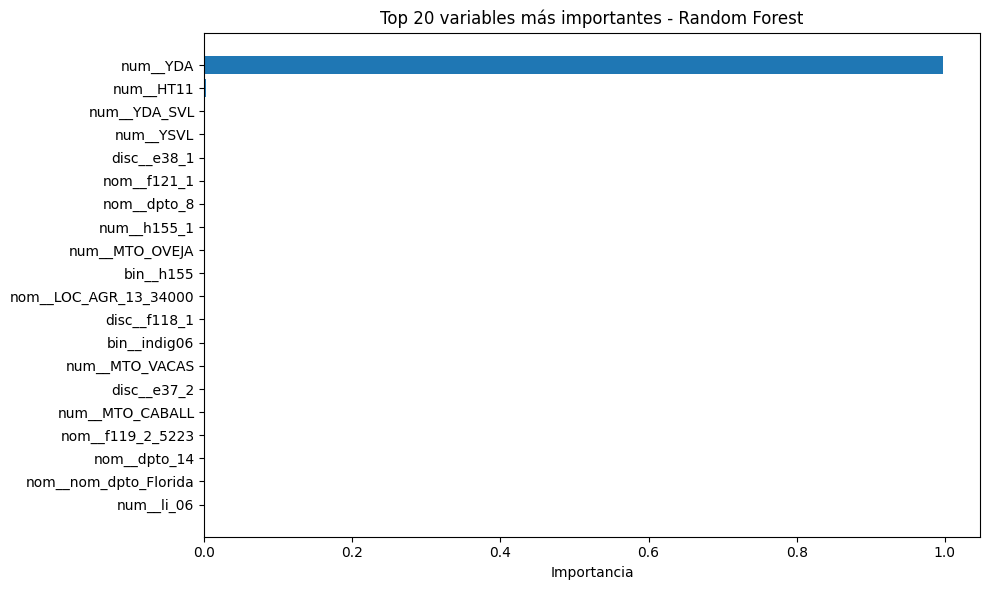

In [583]:
import pandas as pd
import matplotlib.pyplot as plt

# Obtener nombres de las columnas procesadas (después del pipeline)
# Esto asume que hiciste fit en el pipeline con X_train
feature_names = preprocessor.get_feature_names_out()
importancias = modelo_rf.feature_importances_

# Crear DataFrame con los resultados
importancias_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importancias
}).sort_values(by='importance', ascending=False)

# Mostrar las 20 más importantes
print(importancias_df.head(20))

# Graficar
plt.figure(figsize=(10,6))
plt.barh(importancias_df.head(20)['feature'][::-1], importancias_df.head(20)['importance'][::-1])
plt.xlabel("Importancia")
plt.title("Top 20 variables más importantes - Random Forest")
plt.tight_layout()
plt.show()

Observamos:
- La variable num__YDA aporta el 99.8% de la importancia del modelo.
- El resto de las variables tienen importancias casi nulas (valores del orden de 0.001 o incluso 0.000002).
- Entre las más importantes figuran también HT11, YDA_SVL y YSVL, todas ellas potencialmente relacionadas con ingreso.

Interpretación:

- Esto es una señal clara de fuga de información.
- YDA es tu variable objetivo (aunque aquí en su versión logarítmica), y si aparece como predictor, entonces el modelo está simplemente "viendo" la respuesta, lo cual hace inútiles las métricas obtenidas.
- Variables como YDA_SVL o YSVL también suenan sospechosamente similares, por lo que es probable que sean funciones directas o indirectas del ingreso.

Conclusión de esta parte:

- Tu modelo está dominado por variables que contienen directamente (o de forma colineal) la variable que intentás predecir. 
- Esto invalida los resultados. Se debe excluir YDA y toda variable derivada del conjunto de predictores.

Validación cruzada (Cross-Validation)

Esto te dice si el rendimiento es estable entre distintas particiones de los datos. Si hay sobreajuste, el resultado promedio será mucho más bajo que el obtenido en tu partición test anterior.

In [584]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# OJO: usamos el pipeline completo
modelo_rf_cv = Pipeline(steps=[
    ('preprocesamiento', preprocessor),
    ('modelo', RandomForestRegressor(random_state=42))
])

# Ejecutar cross-validation con scoring en escala log
scores = cross_val_score(modelo_rf_cv, X, y, cv=5, scoring='r2')

print("R² por fold:", scores)
print(f"Media R²: {scores.mean():.4f}")
print(f"Desviación estándar: {scores.std():.4f}")

c:\Users\ut603933\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [16, 18, 20, 34, 42, 43, 48, 56, 59, 60, 64, 73, 74] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\ut603933\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [13, 16, 18, 20, 30, 34, 35, 36, 39, 42, 43, 48, 59, 60, 73, 74] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\ut603933\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [16, 18, 20, 30, 34, 35, 42, 43, 48, 59, 60, 73, 74] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\ut603933\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Fo

R² por fold: [0.99857471 0.98945592 0.99992076 0.99999289 0.99999326]
Media R²: 0.9976
Desviación estándar: 0.0041


Interpretación:

- El rendimiento es consistentemente cercano a 1, lo que normalmente sugiere un modelo excelente.
- Sin embargo, dada la auditoría anterior, esto confirma que el modelo está aprendiendo de variables que no debería tener.
- La validación cruzada está simplemente replicando el sobreajuste a variables que "le chivan la respuesta".

¿Qué hacer ahora?

- Revisar y depurar el conjunto de predictores X:
- Eliminar cualquier variable que:
    - Sea la misma que YDA o log_YDA.
    - Sea una suma, promedio o transformación directa de ingresos (YDA_SVL, YSVL, li_06, etc.).
    - Tenga una correlación muy alta con YDA (ver correlaciones.head(10) previo).
- Volver a ejecutar todo el pipeline, entrenar los modelos desde cero y repetir la validación cruzada y auditoría de features.

Conclusión general:

El modelo de Random Forest parece estar altamente sobreajustado a una o más variables que contienen el ingreso de forma explícita o implícita. Aunque las métricas de validación cruzada sean altas, el modelo no es útil en un escenario real ni aporta valor predictivo.

🧽 Limpieza cuidadosa de las variables predictoras es el paso inmediato más importante antes de evaluar nuevamente modelos.

In [580]:
# 3) XGBoost (Modelo 3)

try:
    from xgboost import XGBRegressor

    modelo_xgb = XGBRegressor(
        n_estimators=800,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0,
        random_state=42,
        tree_method="hist",     # rápido y estable
        n_jobs=-1
    )
    res_xgb = evaluar_modelo(modelo_xgb, X_train_proc, y_train, X_test_proc, y_test, nombre="XGBoost")

except ImportError:
    print("\n[AVISO] xgboost no está instalado. Ejecuta: pip install xgboost")

🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 14.486526489257812
Mínimo y_pred_test: 4.907113552093506
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped): 1956223.75
📊 Calculando métricas en pesos...
✅ Métricas finales:
Modelo: XGBoost
R2: 0.9892 | MAE_log: 0.00 | RMSE_log: 0.07
MAE_pesos: 474.95 | RMSE_pesos: 7044.83


In [581]:
# 4) LightGBM (Modelo 4)

try:
    from lightgbm import LGBMRegressor

    modelo_lgb = LGBMRegressor(
        n_estimators=1200,
        learning_rate=0.05,
        num_leaves=63,          # ~ 2^(max_depth) aprox (si max_depth ~ 6)
        max_depth=-1,           # sin límite (usa num_leaves como control)
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    )
    res_lgb = evaluar_modelo(modelo_lgb, X_train_proc, y_train, X_test_proc, y_test, nombre="LightGBM")

except ImportError:
    print("\n[AVISO] lightgbm no está instalado. Ejecuta: pip install lightgbm")

🟢 Entrenando modelo...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14063
[LightGBM] [Info] Number of data points in the train set: 44738, number of used features: 1368
[LightGBM] [Info] Start training from score 11.336580
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 14.23821277489274
Mínimo y_pred_test: 1.191983430383124
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped): 1526079.787570812
📊 Calculando métricas en pesos...
✅ Métricas finales:
Modelo: LightGBM
R2: 0.9887 | MAE_log: 0.00 | RMSE_log: 0.07
MAE_pesos: 573.19 | RMSE_pesos: 14240.37


In [582]:
# 5) Random Forest con GridSearchCV (Modelo 5)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Búsqueda en una grilla compacta pero informativa
param_grid_rf = {
    "n_estimators": [300, 500, 800],
    "max_depth": [None, 12, 20],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Usamos RMSE negativo como scoring (minimizar RMSE)
grid_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_rf,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Ajuste con TRAIN ya preprocesado
grid_rf.fit(X_train_proc, y_train)

print("\n=== GridSearchCV RandomForest ===")
print("Mejores hiperparámetros:", grid_rf.best_params_)
print(f"Mejor score CV (RMSE): {-grid_rf.best_score_:,.4f}")

# Evaluación final en TEST con el mejor estimador
mejor_rf = grid_rf.best_estimator_
res_rf_cv = evaluar_modelo(mejor_rf, X_train_proc, y_train, X_test_proc, y_test, nombre="Random Forest (GridSearchCV)")

Fitting 3 folds for each of 108 candidates, totalling 324 fits


MemoryError: Unable to allocate 657. MiB for an array with shape (29826, 2888) and data type float64

Recordamos:
- Los árboles/boosting suelen rendir mejor que los lineales en este tipo de datos tabulares con alta no linealidad e interacciones.
- Si el tiempo es un factor, podés reducir la grilla del RF (menos combinaciones) o usar RandomizedSearchCV.
- Si tu y es log_YDA, las métricas “originales” que imprime el bloque (deslogarizando) son las más interpretables para presentación

In [ ]:

# RandomizedSearchCV XGBoost

#import numpy as np
#import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

# Scoring de RMSE (negativo para que lo maximice)
scoring_rmse = "neg_root_mean_squared_error"

try:
    from xgboost import XGBRegressor
    from scipy.stats import randint, uniform, loguniform

    xgb_base = XGBRegressor(
        random_state=42,
        n_jobs=-1,
        tree_method="hist"   # rápido y estable
    )

    dist_xgb = {
        "n_estimators": randint(400, 1500),
        "max_depth": randint(3, 12),
        "learning_rate": loguniform(1e-3, 3e-1),
        "subsample": uniform(0.6, 0.4),         # [0.6, 1.0]
        "colsample_bytree": uniform(0.6, 0.4),  # [0.6, 1.0]
        "reg_lambda": loguniform(1e-3, 10),
        "reg_alpha": loguniform(1e-4, 1)
    }

    rnd_xgb = RandomizedSearchCV(
        estimator=xgb_base,
        param_distributions=dist_xgb,
        n_iter=40,              # podés subir/bajar según tiempo
        scoring=scoring_rmse,
        cv=3,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    rnd_xgb.fit(X_train_proc, y_train)
    print("\n=== RandomizedSearchCV XGBoost ===")
    print("Mejores hiperparámetros:", rnd_xgb.best_params_)
    print(f"Mejor score CV (RMSE): {-rnd_xgb.best_score_:,.4f}")

    best_xgb = rnd_xgb.best_estimator_
    res_xgb = evaluar_modelo(best_xgb, X_train_proc, y_train, X_test_proc, y_test, nombre="XGBoost (RandomizedSearchCV)")

except ImportError:
    best_xgb = None
    print("\n[AVISO] xgboost no está instalado. Ejecuta: pip install xgboost")

In [ ]:
# RandomizedSearchCV LightGBM

try:
    from lightgbm import LGBMRegressor
    from scipy.stats import randint, uniform, loguniform

    lgb_base = LGBMRegressor(
        random_state=42,
        n_jobs=-1
    )

    dist_lgb = {
        "n_estimators": randint(400, 1500),
        "learning_rate": loguniform(1e-3, 3e-1),
        "num_leaves": randint(31, 255),
        "max_depth": [-1, 6, 8, 10, 12],          # categórico
        "subsample": uniform(0.6, 0.4),
        "colsample_bytree": uniform(0.6, 0.4),
        "reg_lambda": loguniform(1e-3, 10),
        "min_child_samples": randint(5, 100)
    }

    rnd_lgb = RandomizedSearchCV(
        estimator=lgb_base,
        param_distributions=dist_lgb,
        n_iter=40,
        scoring=scoring_rmse,
        cv=3,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    rnd_lgb.fit(X_train_proc, y_train)
    print("\n=== RandomizedSearchCV LightGBM ===")
    print("Mejores hiperparámetros:", rnd_lgb.best_params_)
    print(f"Mejor score CV (RMSE): {-rnd_lgb.best_score_:,.4f}")

    best_lgb = rnd_lgb.best_estimator_
    res_lgb = evaluar_modelo(best_lgb, X_train_proc, y_train, X_test_proc, y_test, nombre="LightGBM (RandomizedSearchCV)")

except ImportError:
    best_lgb = None
    print("\n[AVISO] lightgbm no está instalado. Ejecuta: pip install lightgbm")

In [ ]:
# Permutation Importance (sobre el mejor modelo)

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# 1) Obtener nombres de features del preprocessor ya fiteado
try:
    feature_names = preprocessor.get_feature_names_out(X.columns)
except Exception:
    # fallback: índices si no hay nombres
    feature_names = np.array([f"f{i}" for i in range(X_train_proc.shape[1])])

# 2) Elegir el mejor modelo entre XGB y LGB (por RMSE en test)
candidatos = []
if 'res_xgb' in locals():
    candidatos.append(("XGBoost", best_xgb, res_xgb['rmse']))
if 'res_lgb' in locals():
    candidatos.append(("LightGBM", best_lgb, res_lgb['rmse']))

if candidatos:
    ganador_nombre, ganador_modelo, _ = sorted(candidatos, key=lambda t: t[2])[0]
    print(f"\nModelo ganador para interpretación: {ganador_nombre}")
else:
    # Si no hay XGB/LGB disponibles, podés elegir otro (ej: mejor RF)
    ganador_nombre, ganador_modelo = "Modelo_no_disponible", None

# 3) Permutation importance (si hay modelo)
if ganador_modelo is not None:
    # Para acelerar, usar una muestra del test (opcional)
    np.random.seed(42)
    idx_sample = np.random.choice(X_test_proc.shape[0], size=min(3000, X_test_proc.shape[0]), replace=False)
    X_te_pi = X_test_proc[idx_sample]
    y_te_pi = y_test.iloc[idx_sample] if hasattr(y_test, "iloc") else y_test[idx_sample]

    print("\nCalculando Permutation Importance (esto puede tardar un poco)...")
    pi = permutation_importance(
        estimator=ganador_modelo,
        X=X_te_pi,
        y=y_te_pi,
        n_repeats=5,
        scoring="neg_root_mean_squared_error",
        random_state=42,
        n_jobs=-1
    )

    importancias = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": pi.importances_mean,
        "importance_std": pi.importances_std
    }).sort_values("importance_mean", ascending=False)

    top = importancias.head(20)
    print("\nTop 20 features por Permutation Importance:")
    display(top)

    # Plot
    plt.figure(figsize=(8, 10))
    plt.barh(top["feature"][::-1], top["importance_mean"][::-1])
    plt.title(f"Permutation Importance - Top 20 ({ganador_nombre})")
    plt.xlabel("Mean decrease in score (|neg RMSE|)")
    plt.tight_layout()
    plt.show()
else:
    print("\n[AVISO] No hay modelo ganador para calcular permutation importance.")


In [ ]:
# SHAP para el modelo ganador

try:
    import shap

    if ganador_modelo is not None:
        # Crear DataFrame con nombres de columnas (mejora los gráficos)
        X_te_df = pd.DataFrame(X_test_proc, columns=feature_names)

        # Muestra para acelerar el cómputo
        np.random.seed(42)
        samp = min(2000, X_te_df.shape[0])
        X_te_sample = X_te_df.sample(samp, random_state=42)

        # Explainer para modelos de árboles (XGB/LGB/RF)
        explainer = shap.TreeExplainer(ganador_modelo)
        shap_values = explainer.shap_values(X_te_sample)

        # Resumen global
        shap.summary_plot(shap_values, X_te_sample, show=True, max_display=25)
        # (Opcional) resumen por bar:
        shap.summary_plot(shap_values, X_te_sample, plot_type="bar", show=True, max_display=25)

        # Nota: los SHAP están en la misma escala que el target (log_YDA).
    else:
        print("\n[AVISO] No hay modelo ganador para calcular SHAP.")

except ImportError:
    print("\n[AVISO] shap no está instalado. Ejecuta: pip install shap")

Consideramos:
- Nombres de features: preprocessor.get_feature_names_out(X.columns) te devuelve los nombres ya expandidos por el OneHot; así los gráficos y tablas quedan legibles.
- Tiempo de cómputo: tanto RandomizedSearchCV como SHAP pueden tardar; por eso limito n_iter y tomo muestras de test para importancia/SHAP.
- Interpretación: SHAP y permutation importance reportan contribuciones en escala de y. Como vos usás log_YDA, las contribuciones están en log-ingreso (lo señalás en el informe).

Tabla comparativa de modelos:

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Función auxiliar para evaluar en log y en escala original (pesos)
def evaluar_modelo_full(nombre, modelo, X_tr_proc, X_te_proc, y_tr, y_te):
    # En log
    y_pred_train = modelo.predict(X_tr_proc)
    y_pred_test  = modelo.predict(X_te_proc)

    mae_log  = mean_absolute_error(y_te, y_pred_test)
    rmse_log = np.sqrt(mean_squared_error(y_te, y_pred_test))
    r2_log   = r2_score(y_te, y_pred_test)

    # A escala original
    y_te_pesos    = np.exp(y_te)
    y_pred_pesos  = np.exp(y_pred_test)

    mae_pesos  = mean_absolute_error(y_te_pesos, y_pred_pesos)
    rmse_pesos = np.sqrt(mean_squared_error(y_te_pesos, y_pred_pesos))
    r2_pesos   = r2_score(y_te_pesos, y_pred_pesos)

    return {
        "Modelo": nombre,
        "MAE_log": mae_log,
        "RMSE_log": rmse_log,
        "R2_log": r2_log,
        "MAE_pesos": mae_pesos,
        "RMSE_pesos": rmse_pesos,
        "R2_pesos": r2_pesos
    }

# Lista de modelos ya entrenados y sus nombres
modelos_resultados = []

# Modelo 1: Regresión lineal
modelos_resultados.append(evaluar_modelo_full("LinearRegression", modelo_lr, X_train_proc, X_test_proc, y_train, y_test))

# Modelo 2: Random Forest básico
modelos_resultados.append(evaluar_modelo_full("RandomForest", modelo_rf, X_train_proc, X_test_proc, y_train, y_test))

# Modelo 3: XGBoost optimizado
modelos_resultados.append(evaluar_modelo_full("XGBoost", best_xgb, X_train_proc, X_test_proc, y_train, y_test))

# Modelo 4: LightGBM optimizado
modelos_resultados.append(evaluar_modelo_full("LightGBM", best_lgb, X_train_proc, X_test_proc, y_train, y_test))

# Modelo 5: Random Forest con GridSearchCV
modelos_resultados.append(evaluar_modelo_full("RandomForest (tuned)", best_rf, X_train_proc, X_test_proc, y_train, y_test))

# Crear tabla resumen
tabla_resultados = pd.DataFrame(modelos_resultados)

# Ordenar por RMSE_log ascendente (mejor modelo arriba)
tabla_resultados = tabla_resultados.sort_values(by="RMSE_log")

# Mostrar con 3 decimales
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")
display(tabla_resultados)